Saturation curves for SM-omics and ST<br>

Input files are generated by counting number of unique molecules and number of annotated reads per annotated region after adjusting for sequencing depth, in downsampled fastq files (proportions 0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1) processed using ST-pipeline.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10005CN48_C1_uniq_molecules_per_region.txt<br>
10005CN48_D1_uniq_molecules_per_region.txt<br>
10005CN48_E1_uniq_molecules_per_region.txt<br>
10015CN60_E2_uniq_molecules_per_region.txt<br>
10015CN84_C2_uniq_molecules_per_region.txt<br>
10015CN84_D2_uniq_molecules_per_region.txt<br>

To generate SM-omics vs Visium, saturation curve for the entire tissue section, download:<br>
10015CN108_C1_uniq_molecules.txt<br>
10015CN108fl_E2_uniq_molecules.txt<br>
5005CN107_D2_uniq_molecules.txt<br>
visium_A1_uniq_molecules.txt<br>
visium_B1_uniq_molecules.txt<br>
visium_D1_uniq_molecules.txt <br>


In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    """
    # The samples are run in triplicate based on condition
    condition = ['sm-omics', 'ST']

    if row['Name'] in ['10015CN84_D2', '10015CN84_C2', '10015CN60_E2']:
        return condition[0]
    
    elif row['Name'] in ['10005CN48_C1','10005CN48_D1','10005CN48_E1']:
        return condition[1]
    

In [3]:
# Load input files
path = '../../smomics_data'

stats_list = []

samples_list = ['10005CN48_C1', '10005CN48_D1', '10005CN48_E1', '10015CN84_D2', '10015CN84_C2', '10015CN60_E2']
    
for filename in samples_list:
    
    cond_file = pd.read_csv(os.path.join(path, filename + '_uniq_molecules_per_region.txt'), sep = '\t')
    
    cond_file['Condition'] = cond_file.apply(lambda row: condition(row), axis = 1)
    
    stats_list.append(cond_file)

# Concat all files
cond_merge = pd.concat(stats_list)
    

In [4]:
prop_list = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]

cond_list = []
for label, df in cond_merge.groupby(['Condition', 'Name', 'Annotated_region']):
    
    # Sort df by annotated reads
    df.sort_values(by='Annotated_reads', inplace=True)
    
    df['Prop_annot_reads'] = prop_list
        
    cond_list.append(df)
    
# Concatenate all dfs in list
plot_df_tmp = pd.concat(cond_list)

# Remove 'unknown' regions, if any
plot_df_big = plot_df_tmp[plot_df_tmp['Annotated_region'] != 'Unknown']


In [5]:
# Prepare samples for plotting
ll = []

for label, df in plot_df_big.groupby(['Name']):
    # Get max annotated reads
    max_annot = df['Annotated_reads'].max()
    
    # Get tot number of uniq mol at that amount of annotated reads
    tot_uniq_mol = df[df['Annotated_reads'] == max_annot]['Unique_molecules'].sum()
    
    df['Prop_uniq_mol'] = df['Unique_molecules'] / tot_uniq_mol
    ll.append(df)

# Concatenate all dfs in list
prop_df = pd.concat(ll)
plot_dict = {}

# Get a df per annotated region
for label, df in prop_df.groupby(['Annotated_region']):
        
    df.drop(['Num reads', 'Annotated_reads', 'Unique_molecules'], axis=1, inplace=True)

    plot_dict[label] = df

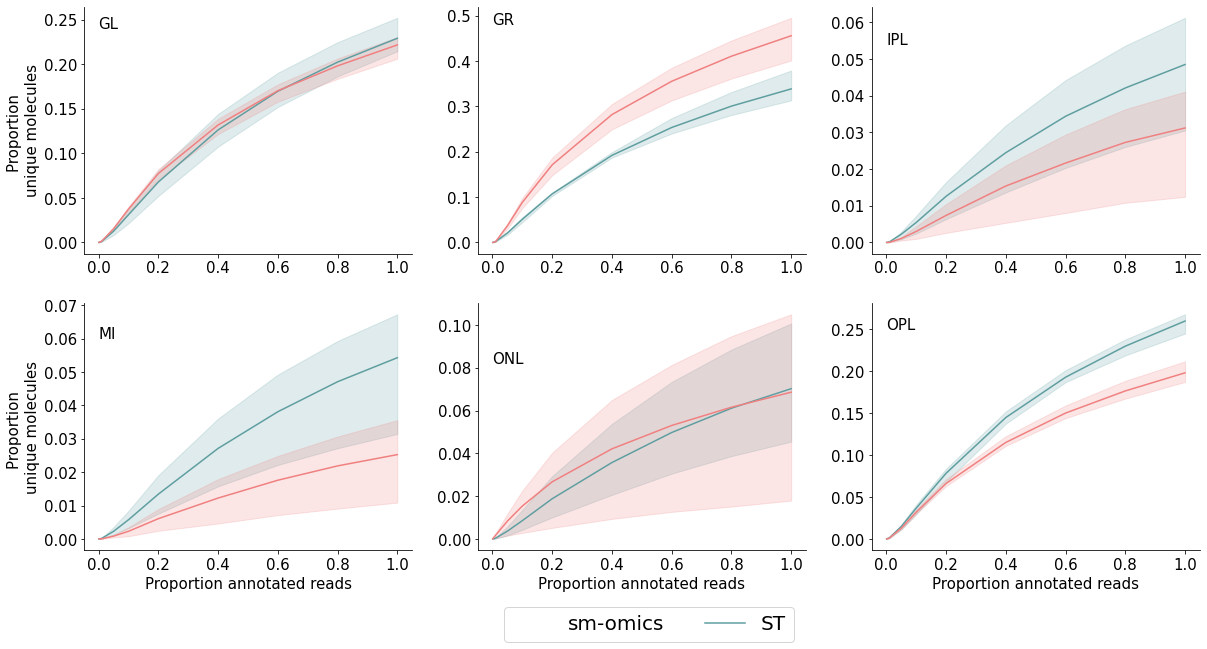

In [6]:
#Plot 
fig = plt.figure(figsize=(20, 10))
# for a 2x3 subplot
axes = []
for row_idx in range(0,2):
    for col_idx in range(0,3):
        ax = plt.subplot2grid((2, 3), (row_idx, col_idx))
        axes.append(ax) 

x="Prop_annot_reads"
y="Prop_uniq_mol"
hue='Condition'
hue_order=['sm-omics', 'ST']
palette = ['cadetblue', 'lightcoral']
err_style="band"
ci=99

################ LINE PLOT
count = 0
for key, value in plot_dict.items():
    
    ax=axes[count]
    
    if count == 4:
        sns.lineplot(x=x, y=y, data=value, ci=ci, err_style=err_style, hue=hue, 
                 palette = palette, ax=ax, hue_order=hue_order)
    else:
        sns.lineplot(x=x, y=y, data=value, ci=ci, err_style=err_style, hue=hue, 
                 palette = palette, ax=ax, hue_order=hue_order, 
                legend=False)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
    # X and y label size
    if count in [3, 4, 5]:
        ax.set_xlabel("Proportion annotated reads", fontsize=15)
    else:
        ax.set_xlabel("")
        
    if count in [0, 3]:
        ax.set_ylabel("Proportion \nunique molecules", fontsize=15)
    else:
        ax.set_ylabel("")
    
    # Set ticks size
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(axis='x', labelsize=15)
    
    # change background color
    back_c = 'white'
    ax.set_facecolor(back_c)
    ax.grid(False)
    
    # text
    if count == 0:
        ax.text(0, 0.24, key, fontsize=15)
    elif count == 1:
        ax.text(0, 0.48, key, fontsize=15)
    elif count == 2:
        ax.text(0, 0.054, key, fontsize=15)
    elif count == 3:
        ax.text(0, 0.06, key, fontsize=15)
    elif count == 4:
        ax.text(0, 0.082, key, fontsize=15)
    elif count == 5:
        ax.text(0, 0.25, key, fontsize=15)
        
    
    count += 1

# LEGEND
handles, labels = axes[4].get_legend_handles_labels()
axes[4].legend(handles=handles[0:], labels=hue_order,loc='center left', bbox_to_anchor=(0.05, -0.3), ncol=2, fontsize=20)
        

plt.show()

In [7]:
value[value['Prop_annot_reads'] == 1]

,Name,Annotated_region,Condition,Prop_annot_reads,Prop_uniq_mol
53,10005CN48_C1,OPL,ST,1.0,0.186934
53,10005CN48_D1,OPL,ST,1.0,0.194996
53,10005CN48_E1,OPL,ST,1.0,0.211460
47,10015CN60_E2,OPL,sm-omics,1.0,0.266461
47,10015CN84_C2,OPL,sm-omics,1.0,0.244528
47,10015CN84_D2,OPL,sm-omics,1.0,0.267469
